## 1. CNN Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/My Drive/archive.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Celeb-DF Preprocessed/val/fake/id52_id54_0002_frame540_face14.jpg  
  inflating: /content/Celeb-DF Preprocessed/val/fake/id52_id54_0003_frame300_face6.jpg  
  inflating: /content/Celeb-DF Preprocessed/val/fake/id52_id54_0003_frame60_face2.jpg  
  inflating: /content/Celeb-DF Preprocessed/val/fake/id52_id54_0004_frame240_face5.jpg  
  inflating: /content/Celeb-DF Preprocessed/val/fake/id52_id54_0004_frame360_face8.jpg  
  inflating: /content/Celeb-DF Preprocessed/val/fake/id52_id54_0005_frame60_face2.jpg  
  inflating: /content/Celeb-DF Preprocessed/val/fake/id52_id54_0007_frame240_face5.jpg  
  inflating: /content/Celeb-DF Preprocessed/val/fake/id52_id54_0007_frame60_face2.jpg  
  inflating: /content/Celeb-DF Preprocessed/val/fake/id52_id54_0008_frame0_face2.jpg  
  inflating: /content/Celeb-DF Preprocessed/val/fake/id52_id54_0008_frame240_face9.jpg  
  inflating: /content/Celeb-DF Preprocessed/val/fake/id52_id54_

In [3]:
import os
print(os.listdir("/content/"))

['.config', 'drive', 'Celeb-DF Preprocessed', 'sample_data']


In [4]:
import os

dataset_path = "/content/Celeb-DF Preprocessed"

print("Train:", os.listdir(os.path.join(dataset_path, "train")))
print("Validation:", os.listdir(os.path.join(dataset_path, "val")))
print("Test:", os.listdir(os.path.join(dataset_path, "test")))

Train: ['real', 'fake']
Validation: ['real', 'fake']
Test: ['real', 'fake']


In [5]:
def count_images(folder):
    fake_count = len(os.listdir(os.path.join(folder, "fake")))
    real_count = len(os.listdir(os.path.join(folder, "real")))
    print(f"Fake: {fake_count}, Real: {real_count}")

print("Train Set:")
count_images(os.path.join(dataset_path, "train"))

print("Validation Set:")
count_images(os.path.join(dataset_path, "val"))

print("Test Set:")
count_images(os.path.join(dataset_path, "test"))

Train Set:
Fake: 34865, Real: 10901
Validation Set:
Fake: 9961, Real: 3114
Test Set:
Fake: 4982, Real: 1558


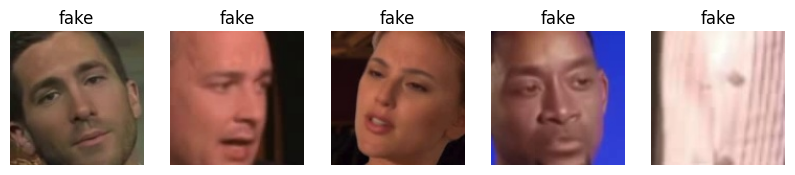

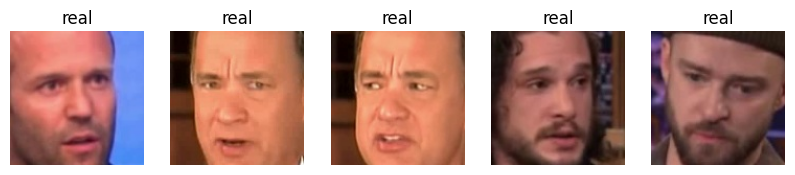

In [6]:
import matplotlib.pyplot as plt
import cv2
import random

def show_images(folder, label, num_images=5):
    path = os.path.join(dataset_path, folder, label)
    images = random.sample(os.listdir(path), num_images)

    plt.figure(figsize=(10,5))
    for i, img in enumerate(images):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")
    plt.show()

# Show Fake Images
show_images("train", "fake")

# Show Real Images
show_images("train", "real")

There's an imbalance in the dataset, with more fake images than real images. We will address this in preprocessing.

## Data Preprocessing

We will:
- Resize all images to 128x128 (to reduce memory usage)
- Normalize pixel values (scale between 0 and 1)
- Apply Augmentation (for real images to balance classes)



In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_dir = "/content/Celeb-DF Preprocessed/train"
val_dir = "/content/Celeb-DF Preprocessed/val"
test_dir = "/content/Celeb-DF Preprocessed/test"

# Image size and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Data augmentation for real images to balance dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load train dataset
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Load validation dataset
val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Load test dataset
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # No need to shuffle test set
)

Found 45766 images belonging to 2 classes.
Found 13075 images belonging to 2 classes.
Found 6540 images belonging to 2 classes.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (Fake/Real)
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

This creates a 3-layer CNN model optimized for binary classification.

In [10]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20
)

Epoch 1/20
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 209s 146ms/step - accuracy: 0.7612 - loss: 0.5452 - val_accuracy: 0.7647 - val_loss: 0.5148
Epoch 2/20
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 264s 147ms/step - accuracy: 0.7692 - loss: 0.5218 - val_accuracy: 0.7725 - val_loss: 0.5046
Epoch 3/20
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 261s 146ms/step - accuracy: 0.7742 - loss: 0.5109 - val_accuracy: 0.8005 - val_loss: 0.4636
Epoch 4/20
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 260s 145ms/step - accuracy: 0.7874 - loss: 0.4876 - val_accuracy: 0.8133 - val_loss: 0.4332
Epoch 5/20
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 209s 145ms/step - accuracy: 0.7950 - loss: 0.4697 - val_accuracy: 0.8158 - val_loss: 0.4203
Epoch 6/20
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 262s 146ms/step - accuracy: 0.8011 - loss: 0.4545 - val_accuracy: 0.8211 - val_loss: 0.4110
Epoch 7/20
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 262s 146ms/step - accuracy: 0.8092 - loss: 0.4406 - val_accuracy: 0.8360 - val_loss: 0.3926
Epoch 8/20
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 209s 146ms/step - ac

In [11]:
# Save the trained CNN model
model.save("/content/drive/My Drive/cnn_model.h5")
print("CNN model saved successfully!")

CNN model saved successfully!


In [12]:
# Evaluate CNN model on the test set
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9262 - loss: 0.2567
Test Accuracy: 0.8714, Test Loss: 0.3285


## 2. EfficientNetV2 Model

In [13]:
from tensorflow.keras.applications import EfficientNetV2S

# Load EfficientNetV2 base model
base_model = EfficientNetV2S(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze pre-trained layers

# new model with EfficientNetV2 as the backbone
transfer_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
transfer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_transfer = transfer_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20
)

# Save the Transfer Learning model
transfer_model.save("/content/drive/My Drive/transfer_model.h5")
print("Transfer Learning model saved successfully!")

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 323s 192ms/step - accuracy: 0.7453 - loss: 0.8797 - val_accuracy: 0.7618 - val_loss: 0.5271
Epoch 2/20
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 243s 169ms/step - accuracy: 0.7629 - loss: 0.5500 - val_accuracy: 0.7618 - val_loss: 0.5341
Epoch 3/20
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 236s 165ms/step - accuracy: 0.7606 - loss: 0.5494 - val_accuracy: 0.7618 - val_loss: 0.5454
Epoch 4/20
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 262s 165ms/step - accuracy: 0.7596 - loss: 0.5515 - val_accuracy: 0.7618 - val_loss: 0.5490
Epoch 5/20
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 260s 163ms/step - accuracy: 0.7602 - loss: 0.5509 - val_accuracy: 0.7618 - val_loss: 0.5490
Epoch 6/20
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 243s 169ms/step - accuracy: 0.7625 - loss: 0.5481 - val_accuracy: 0.7618 - val_loss: 0.5490
Epoch 7/20
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 255s 164ms/step - accuracy: 0.7620 - loss: 0.5488 - val_accuracy: 0.7618 - val_loss: 0.5490
Epoch 8/20


Transfer Learning model saved successfully!


## Comparing CNN vs Transfer Learning

In [14]:
from tensorflow.keras.models import load_model

# Load both models
cnn_model = load_model("/content/drive/My Drive/cnn_model.h5")
transfer_model = load_model("/content/drive/My Drive/transfer_model.h5")

# Evaluate both models on the test data
cnn_results = cnn_model.evaluate(test_data)
transfer_results = transfer_model.evaluate(test_data)

# Print comparison
print(f"CNN Model - Loss: {cnn_results[0]:.4f}, Accuracy: {cnn_results[1]:.4f}")
print(f"Transfer Learning Model - Loss: {transfer_results[0]:.4f}, Accuracy: {transfer_results[1]:.4f}")

205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9262 - loss: 0.2567
205/205 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - accuracy: 0.9668 - loss: 0.3125
CNN Model - Loss: 0.3285, Accuracy: 0.8714
Transfer Learning Model - Loss: 0.5490, Accuracy: 0.7618


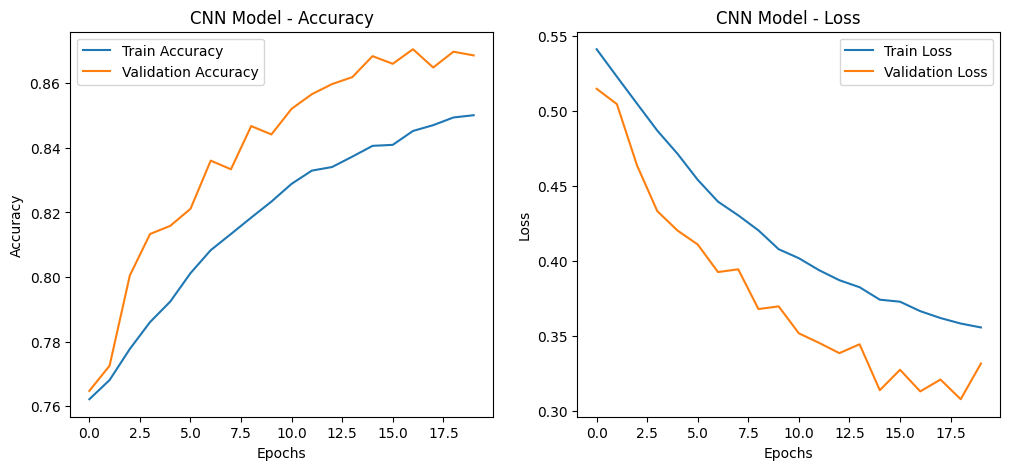

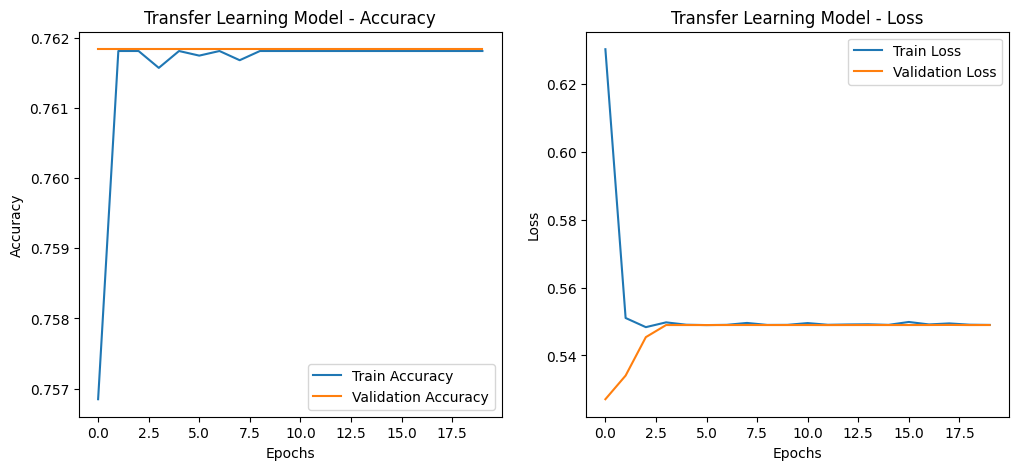

In [15]:
import matplotlib.pyplot as plt

# Function to plot accuracy & loss
def plot_history(history, title):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot CNN performance
plot_history(history, "CNN Model")

# Plot Transfer Learning performance
plot_history(history_transfer, "Transfer Learning Model")